## Pulsar-timing outlier study template 

#### Michele Vallisneri and Rutger van Haasteren, v. 2016/09/08

This notebook should work without changes in Python 2.7 and >= 3.4.

In [3]:
from __future__ import print_function

A bunch of imports follows. Here are nonstandard ones.

* `libstempo`, from http://github.com/vallis/libstempo, which itself requires a source/binary installation of `tempo2` (https://bitbucket.org/psrsoft/tempo2)
* `numdifftools` (can be installed with `pip`)
* `corner` (again, `pip`)
* R. van Haasteren's `piccard`, from https://github.com/vhaasteren/piccard. Note that `piccard` requires an OpenMP-enabled compiler. On OS X, use `gcc`, or Homebrew's `llvm` (`brew install llvm; export CC=/usr/local/opt/llvm/bin/clang; export CXX=/usr/local/opt/llvm/bin/clang++`). Then `python setup.py install` inside `piccard`'s source directory. Ah, you'd better also `pip install healpy` first.
* `nutstrajectory`, included in this directory

In [4]:
# avoid an openMP complaint if it's imported by multiple libraries
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [ ]:
import os, sys, glob, tempfile, pickle
import numpy as np
import scipy.linalg as sl, scipy.optimize as so
import matplotlib.pyplot as plt

import libstempo as lt, libstempo.toasim as lts, libstempo.plot as ltp
import numdifftools as nd
import corner
import piccard as pic
from nutstrajectory import nuts6

%matplotlib inline

Fixing a little problem with `piccard`; patch will be propagated upstream ASAP.

In [6]:
def monkey__init__(self, likob, p, hessian, **kwargs):
    """Initialize the whitened likelihood with a maximum and a hessian of
    the parameter space
    """
    self.likob = likob
    self._mu = p.copy()

    # Set the inverse square root
    self.calc_invsqrt(hessian)

    # TODO: Do this through the original __init__ of likelihoodWrapper
    self.initBounds()
    self._cachefunc = None
    self._p = None              # Cached values for coordinates
    self._x = None              # Cached values for coordinates

In [7]:
pic.whitenedLikelihood.__init__ = monkey__init__

OK, here we configure the name of the pulsar, the maximum number of observations (so `tempo2` does not choke), and a run descriptor that will disable the outlier analysis (i.e., perform a standard single-pulsar analysis) if it contains the string `outno`.

If you're running this notebook from the command line, change `if True` to `if False`, so that the notebook will rely on environment variables for configuration. This allows running it from the command line with `runipy` (`conda install runipy`, if you have `conda`, or `pip install runipy`). For instance (in bash at least)

    # PSR=J1713+0747 PSROPT= runipy outlier-template.ipynb

In [8]:
if False:
    os.environ['PSR'] = 'J0030+0451-sim'
    os.environ['PSROPT'] = ''
    os.environ['MAXOBS'] = '30000'

In [9]:
psr = os.environ['PSR']
sfx = os.environ['PSROPT'] # '-outno' for no outliers

try:
    maxobs = int(os.environ['MAXOBS'])
except KeyError:
    maxobs = 20000

You'll need to modify this block so that it finds the right par and tim file.

In [12]:
if os.path.isdir('release'):
    parfile = glob.glob('release/par/{0}*.par'.format(psr))[0]
    timfile = glob.glob('release/tim/{0}*.tim'.format(psr))[0]
elif os.path.isdir('working'):
    parfile = glob.glob('working/partim/{0}*.par'.format(psr))[0]
    timfile = glob.glob('working/partim/{0}*.tim'.format(psr))[0]
else:
    parfile = './' + psr + sfx + '.par'
    timfile = './' + psr + sfx + '.tim'

print(parfile,timfile)

./J0030+0451-sim.par ./J0030+0451-sim.tim


Create a `piccard` datafile.

In [16]:
h5file = psr + sfx + '.h5'

if not os.path.isfile(h5file):
    # add to a piccard datafile

    t2df = pic.DataFile(h5file)
    t2df.addTempoPulsar(parfile,timfile,maxobs=maxobs)

Create a Piccard likelihood object. Note the options for including various kinds of noises, for the number of red-noise components, for jitter-like noise (necessary for NANOGrav datasets).

In [17]:
# create a Piccard likelihood object

likob = pic.hmcLikelihood(h5file) #, sort='jitterext')
modeldict = likob.makeModelDict(nfreqs=20, incRedNoise=True, noiseModel='powerlaw',
                                incOutliers=('outno' not in sfx), \
                                noisePrior="flatlog", varyEfac=True, separateEfacs=True, \
                                incEquad=True, separateEquads=True, \
                                ndmfreqs=0, incDM=False, dmModel='dmpowerlaw', \
                                incCEquad=True, separateCEquads=True, \
                                incBWM=False, incGWB=False, gwbModel='powerlaw', \
                                incPsrBWM=False, signPsrBWM=-0.5, varyBWMSign=False, nPsrBWM=1, \
                                likfunc='mark15' if ('outno' not in sfx) else 'mark14',
                                expandJitter=True, priorDraws=False)
likob.initModel(modeldict, fromFile=False, verbose=False)

We have a look at the complete set of parameters (including noise hyperparameters, timing-model parameters, red-noise coefficients, and jitter epoch amplitudes). The hyperparameters are at the top, and we count them. Here `outlier_prob` is the outlier-probability hyperparameter; `Offset` is the first timing-model parameter. There's no jitter since this dataset does not have multiple-frequency data.

In [21]:
reslice = np.arange(0, likob.dimensions)

parnames = []
for pd in likob.pardes:
    ii = pd['index']
    if ii >= 0 and ii in reslice:
        print(ii,pd['id'])
        parnames.append(pd['id'])

nhyperpars = parnames.index('Offset')

0 efacJ0030+0451
1 equadJ0030+0451
2 RN-Amplitude
3 RN-spectral-index
4 outlier_prob_J0030+0451
5 Offset
6 RAJ
7 DECJ
8 F0
9 F1
10 PMRA
11 PMDEC
12 PX
13 2.89554777168e-09
14 2.89554777168e-09
15 5.79109554335e-09
16 5.79109554335e-09
17 8.68664331503e-09
18 8.68664331503e-09
19 1.15821910867e-08
20 1.15821910867e-08
21 1.44777388584e-08
22 1.44777388584e-08
23 1.73732866301e-08
24 1.73732866301e-08
25 2.02688344017e-08
26 2.02688344017e-08
27 2.31643821734e-08
28 2.31643821734e-08
29 2.60599299451e-08
30 2.60599299451e-08
31 2.89554777168e-08
32 2.89554777168e-08
33 3.18510254884e-08
34 3.18510254884e-08
35 3.47465732601e-08
36 3.47465732601e-08
37 3.76421210318e-08
38 3.76421210318e-08
39 4.05376688035e-08
40 4.05376688035e-08
41 4.34332165752e-08
42 4.34332165752e-08
43 4.63287643468e-08
44 4.63287643468e-08
45 4.92243121185e-08
46 4.92243121185e-08
47 5.21198598902e-08
48 5.21198598902e-08
49 5.50154076619e-08
50 5.50154076619e-08
51 5.79109554335e-08
52 5.79109554335e-08


Now we need to find an approximate maximum of the posterior. We'll save it to a pickle, and if we find that pickle, we won't recompute it.

In [22]:
def func(x):
    ll, _ = likob.logposterior_grad(x)
    
    return -np.inf if np.isnan(ll) else ll

def jac(x):
    _, j = likob.logposterior_grad(x)
    return j

def hess(x):
    return likob.hessian(x)

(How fast are we?)

In [23]:
%timeit func(likob.pstart)

100 loops, best of 3: 4.21 ms per loop


In [24]:
func(likob.pstart)

1448.3784773835278

In [25]:
endpfile = psr + sfx + '-endp.pickle'

In [26]:
%%time
if not os.path.isfile(endpfile):
    # Use L-BFGS-B for larger problems
    endp = likob.pstart
    
    for iter in range(3):
        res = so.minimize(lambda x: -func(x),
                          endp,
                          jac=lambda x: -jac(x),
                          hess=None,
                          method='L-BFGS-B', options={'disp': True})

        endp = res['x']
    
    pickle.dump(endp,open(endpfile,'wb'))
else:
    endp = pickle.load(open(endpfile,'rb'))

CPU times: user 1.92 s, sys: 131 ms, total: 2.05 s
Wall time: 273 ms


The log likelihood is higher, as it should be.

In [28]:
func(endp)

1470.9380283302928

Compute the hessian of the posterior around the maximum (for whitening MCMC jump proposal). Same story re pickle.

In [29]:
hessfile = psr + sfx + '-fullhessian.pickle'

In [30]:
%%time
if not os.path.isfile(hessfile):
    reslice = np.arange(0,nhyperpars)

    def partfunc(x):
        p = np.copy(endp)
        p[reslice] = x
        return likob.logposterior_grad(p)[0]

    ndhessdiag = nd.Hessdiag(func)
    ndparthess = nd.Hessian(partfunc)
    
    # Create a good-enough approximation for the Hessian
    nhdiag = ndhessdiag(endp)
    nhpart = ndparthess(endp[reslice])
    fullhessian = np.diag(nhdiag)
    fullhessian[:nhyperpars,:nhyperpars] = nhpart
    
    pickle.dump(fullhessian,open(hessfile,'wb'))
else:
    fullhessian = pickle.load(open(hessfile,'rb'))

CPU times: user 37.7 s, sys: 2.31 s, total: 40 s
Wall time: 5.34 s


We create a whitened likelihood on top of the existing likelihood, using the hessian. It's parametrized differently, but should have the same value. We can check that.

In [31]:
likob.pstart = endp
wl = pic.whitenedLikelihood(likob,endp,-fullhessian)
wlps = wl.pstart

In [32]:
likob.logposterior(endp)

1470.9380283302928

In [33]:
wl.likob.logposterior(wl.backward(wlps))

1470.9380283302928

We're ready to run the NUTS sampler! Once again, we'll skip this if the relevant chain output file exists already. Note that `runipy` may mistakenly exit at the end of a long run. In that case, just run it again, and it will proceed using the saved files.

The run may take a long time, depending on the number of TOAs in your dataset. For an order of magnitude, consider the time of one likelihood evaluation, times 100 (steps in a NUTS trajectory), times 20000. However, the live output of the function `nuts6`, below, will give you an idea.

In [34]:
chaindir = 'chains_' + psr + sfx

In [35]:
!mkdir -p {chaindir}

In [ ]:
%%time
chainfile = chaindir + '/samples.txt'
if not os.path.isfile(chainfile) or len(open(chainfile,'r').readlines()) < 19999:
    # Run NUTS for 20000 samples, with a burn-in of 1000 samples (target acceptance = 0.6)
    samples, lnprob, epsilon = nuts6(wl.logposterior_grad,20000,1000,
                                     wlps,0.6,
                                     verbose=True,
                                     outFile=chainfile,
                                     pickleFile=chaindir + '/save')

    # check that there were no problems in saving the chain
    # check = np.loadtxt(chaindir + '/samples.txt')
    # if samples.shape[0] != check.shape[0]:
    #     print("Samples mismatch: {} vs {}; saving npy.".format(samples.shape[0],check.shape[0]))
    #     np.save(psr + sfx + '-samples.npy',samples)

Convert back from the whitened parameters to the original (physical parameters).

In [37]:
parsfile = psr + sfx + '-pars.npy'

In [38]:
%%time
if not os.path.isfile(parsfile):
    samples = np.loadtxt(chaindir + '/samples.txt')
    pars = wl.fullbackward(samples[:,:-2])
    np.save(parsfile,pars)
else:
    pars = np.load(parsfile)

CPU times: user 2min 38s, sys: 7.39 s, total: 2min 45s
Wall time: 23 s


In [41]:
pars.shape

(19999, 53)

Plot 2-D posterior densities for the noise hyperparameters and outlier probability.

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Applications/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Applications/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


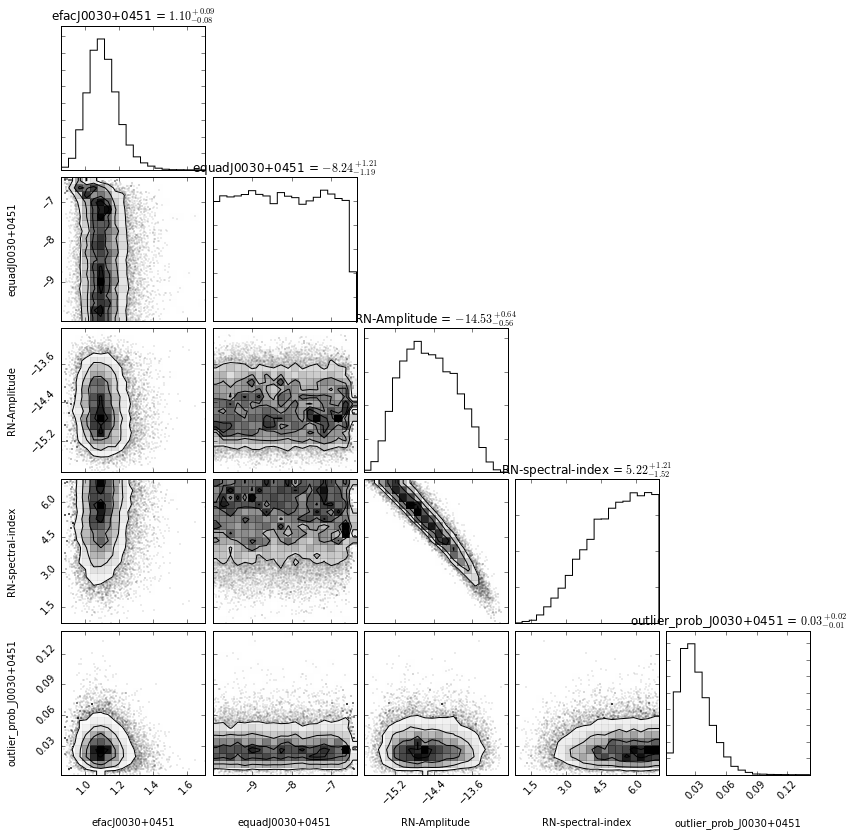

In [39]:
if not os.path.isfile(psr + sfx + '-corner.pdf'):
    corner.corner(pars[:,:nhyperpars],labels=parnames[:nhyperpars],show_titles=True);
    plt.savefig(psr + sfx + '-corner.pdf')

We are ready for the outlier analysis. This is just a post-processing step; the MCMC run already used the outlier-robust likelihood.

First we need a function to compute a vector of outlier probabilities for all observations in the dataset, as a function of a full set of parameters. The function uses the basic pulse period of the pulsar.

In [42]:
likob.ptapsrs[0].P0

0.004865453208293346

In [43]:
def poutlier(p,likob):
    """Invoked on a sample parameter set and the appropriate likelihood,
    returns the outlier probability (a vector over the TOAs) and
    the individual sqrt(chisq) values"""
    
    # invoke the likelihood
    _ = likob.mark15loglikelihood(p)

    # get the piccard pulsar object
    psr = likob.ptapsrs[0]

    r = psr.detresiduals
    N = psr.Nvec

    Pb = psr.outlier_prob # a priori outlier probability for this sample
    P0 = psr.P0           # width of outlier range
    
    PA = 1.0 - Pb
    PB = Pb
    
    PtA = np.exp(-0.5*r**2/N) / np.sqrt(2*np.pi*N)
    PtB = 1.0/P0
    
    num = PtB * PB
    den = PtB * PB + PtA * PA
    
    return num/den, r/np.sqrt(N)

Compute the outlier-probability vector over the MCMC run (since we want to average and histogram it), and save it. All operations going forward are only run if the string `'outno'` is not in `sfx`. If it is, we're running a control non-outlier-robust analysis.

In [44]:
pobsfile = psr + sfx + '-pobs.npy'

In [45]:
%%time
if 'outno' not in sfx:
    if not os.path.isfile(pobsfile):
        nsamples = len(pars)
        nobs = len(likob.ptapsrs[0].Nvec)

        # basic likelihood
        lo = wl.likob.likob.likob

        outps = np.zeros((nsamples,nobs),'d')
        sigma = np.zeros((nsamples,nobs),'d')

        for i,p in enumerate(pars):
            outps[i,:], sigma[i,:] = poutlier(p,lo)

        out = np.zeros((nsamples,nobs,2),'d')
        out[:,:,0], out[:,:,1] = outps, sigma    
        np.save(pobsfile,out)
    else:
        out = np.load(pobsfile)
        outps, sigma = out[:,:,0], out[:,:,1]

CPU times: user 12.1 s, sys: 117 ms, total: 12.2 s
Wall time: 12.3 s


In [46]:
if 'outno' not in sfx:
    avgps = np.mean(outps,axis=0)
    medps = np.median(outps,axis=0)

Plot residuals, showing outliers with more than 10% median probability (or if there are none, with more than 0.05%). You can change this of course.

Big: 3
Plotted: 3


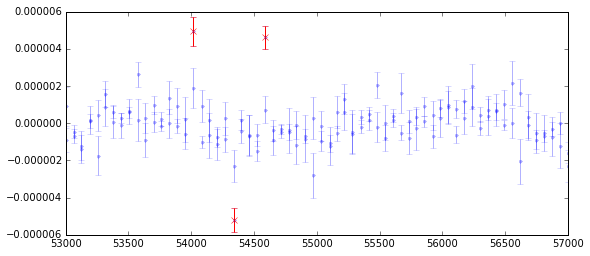

In [47]:
residualplot = psr + sfx + '-residuals.pdf'

if 'outno' not in sfx and not os.path.isfile(residualplot):
    outliers = medps > 0.1
    nout = np.sum(outliers)
    nbig = nout
    
    print("Big: {}".format(nbig))
    
    if nout == 0:
        outliers = medps > 5e-4
        nout = np.sum(outliers)
    
    print("Plotted: {}".format(nout))

    plt.figure(figsize=(9,4))

    psrobj = likob.ptapsrs[0]

    # convert toas to mjds
    toas = psrobj.toas/pic.pic_spd + pic.pic_T0

    # red noise at the starting fit point
    _ = likob.loglikelihood(endp)
    rednoise = psrobj.residuals - psrobj.detresiduals

    # plot tim-file residuals (I think)
    plt.errorbar(toas,psrobj.residuals,yerr=psrobj.toaerrs,fmt='.',alpha=0.3)

    # red noise
    # plt.plot(toas,rednoise,'r-')

    # possible outliers
    plt.errorbar(toas[outliers],psrobj.residuals[outliers],yerr=psrobj.toaerrs[outliers],fmt='rx')

    plt.savefig(residualplot)

Save an outlier report for outliers above 10% probability, showing a number of facts about the suspicious TOAS. You may have to change the `tempo2` flags reported below, because different flags are used in different datasets.

In [ ]:
report = psr + sfx + '-outliers.txt'

if 'outno' not in sfx and not os.path.isfile(report):
    t2 = lt.tempopulsar(parfile,timfile,maxobs=maxobs)

    outliers = medps > 0.1
    nout = np.sum(outliers)
    
    isort = wl.ptapsrs[0].isort
    
    with open(report,'w') as outfile:
        print('# {}'.format(psr),file=outfile)
        print('# using parfile={}, timfile={}'.format(parfile,timfile),file=outfile)
        print('# {} strong (median p > 0.1) outlier candidates'.format(nout),file=outfile)
        
        largest = (-medps).argsort()[:nout]

        for i,k in enumerate(largest):
            j = isort[k]
            print('{filename} {freq:.6f} {toa} -f {f} -chan {chan} -subint {subint} -snr {snr} -pout {pout:.2e}'.format(
                      filename=t2.filename()[j],
                      freq=t2.freqs[j],
                      toa=repr(t2.stoas[j]),
                      f=t2.flagvals('f')[j],
                      chan=t2.flagvals('chan')[j],
                      subint=t2.flagvals('subint')[j],
                      snr=t2.flagvals('snr')[j],
                      pout=medps[k]),
                  file=outfile)

    del t2

Plot histograms of outlier-ness probability and probability-vs.-chisq scatter plots for the most suspicious points.

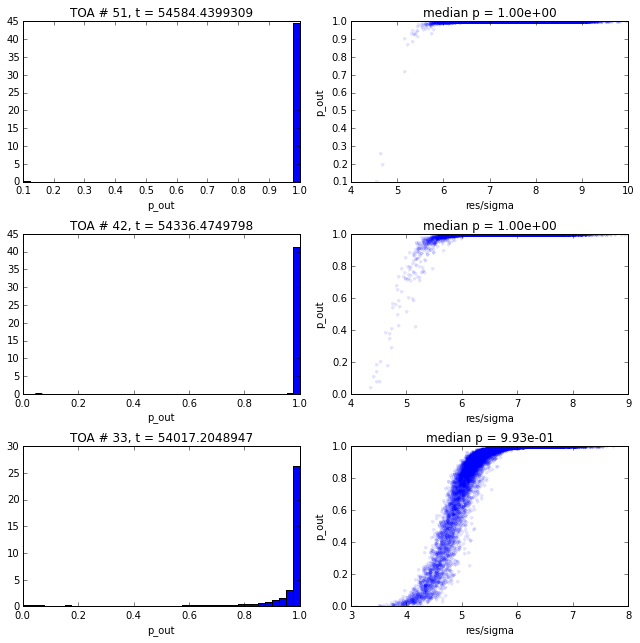

In [49]:
largestplot = psr + sfx + '-largest.pdf'

if 'outno' not in sfx and not os.path.isfile(largestplot):
    outliers = medps > 0.1
    nout = np.sum(outliers)
    
    if nout > 0:
        largest = (-medps).argsort()[:min(nout,10)]

        ncol = len(largest)
        plt.figure(figsize=(9,3*ncol))

        for i,j in enumerate(largest):
            plt.subplot(ncol,2,2*i+1)
            plt.hist(outps[:,j],bins=40,normed=True);
            plt.xlabel('p_out')
            plt.title('TOA # {}, t = {}'.format(j,toas[j]))

            plt.subplot(ncol,2,2*i+2)
            plt.plot(np.abs(sigma[:,j]),outps[:,j],'.',alpha=0.1)
            plt.xlabel('res/sigma'); plt.ylabel('p_out')
            plt.title('median p = {:.2e}'.format(medps[j]))

        plt.tight_layout()

        plt.savefig(largestplot)

Finally, use KDE to get maximum hyperparameter values.

In [50]:
import scipy.interpolate as interp
import scipy.ndimage.filters as filter

def getMax(samples,weights=None,range=None,bins=50):
   if range is None:
       hist, xedges = np.histogram(samples, bins, normed=True, weights=weights)
   else:
       hist, xedges = np.histogram(samples, bins, normed=True, range=range,\
                                  weights=weights)

   xedges = np.delete(xedges, -1) + 0.5*(xedges[1] - xedges[0])

   # gaussian smoothing
   hist = filter.gaussian_filter(hist, sigma=0.75)

   # interpolation
   f = interp.interp1d(xedges, hist, kind='cubic')
   xedges = np.linspace(xedges.min(), xedges.max(), 10000)
   hist = f(xedges)

   return xedges[np.argmax(hist)]

In [51]:
import re

noisefile = psr + sfx + '-noise.txt'

if not os.path.isfile(noisefile):
    with open(noisefile,'w') as outfile:
        for i in range(nhyperpars):
            parname = re.sub(re.sub('\+','\\+',psr),'',parnames[i])
            if parname[-1] == '_':
                parname = parname[:-1]
            print(parname,getMax(pars[:,i]),file=outfile)

That's all folks!